#### Importing different libraries and dataset to start with

In [1]:
#importing necessary libraries to handle and visualize data
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#for building, training and validating the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [3]:
#data set import
df = pd.read_csv('energy_cooling_load_data.csv')
df.head()

,rel_comp,surf_area,wall_area,roof_area,over_ht,orient,glaze_area,glaze_area_dist,cold_load
0,0.98,NaN,294,110.25,NaN,2,0.0,0,21.33
1,0.98,514.5,294,0.00,NaN,3,0.0,0,21.33
2,0.98,514.5,294,0.00,7.0,4,0.0,0,21.33
3,0.98,514.5,294,110.25,7.0,5,0.0,0,21.33
4,0.9,563.5,318.5,122.50,7.0,2,0.0,0,28.28


#### Exploratory Data Analysis and Data Pre Processing

In [4]:
target = df[['cold_load']]
train = df.drop('cold_load',axis=1)

In [5]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 1 columns):
cold_load    768 non-null float64
dtypes: float64(1)
memory usage: 6.1 KB


In [6]:
train.head()

,rel_comp,surf_area,wall_area,roof_area,over_ht,orient,glaze_area,glaze_area_dist
0,0.98,NaN,294,110.25,NaN,2,0.0,0
1,0.98,514.5,294,0.00,NaN,3,0.0,0
2,0.98,514.5,294,0.00,7.0,4,0.0,0
3,0.98,514.5,294,110.25,7.0,5,0.0,0
4,0.9,563.5,318.5,122.50,7.0,2,0.0,0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
rel_comp           764 non-null object
surf_area          766 non-null float64
wall_area          765 non-null object
roof_area          768 non-null float64
over_ht            766 non-null float64
orient             768 non-null int64
glaze_area         768 non-null float64
glaze_area_dist    768 non-null int64
dtypes: float64(4), int64(2), object(2)
memory usage: 48.1+ KB


In [8]:
#apart from Orient column every other column should be numerical
for cols in train.columns.values:
    if cols == 'orient':
        train[cols] = train[cols].astype(str)
    else :
        train[cols] = pd.to_numeric(train[cols],errors = 'coerce')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
rel_comp           762 non-null float64
surf_area          766 non-null float64
wall_area          764 non-null float64
roof_area          768 non-null float64
over_ht            766 non-null float64
orient             768 non-null object
glaze_area         768 non-null float64
glaze_area_dist    768 non-null int64
dtypes: float64(6), int64(1), object(1)
memory usage: 48.1+ KB


##### Now we check for outliers and remove them

In [10]:
#save all categorical columns in list
cat_col = [col for col in train.columns.values if train[col].dtype == 'object']
#dataframe with categorical features
x_cat = train[cat_col]
x_num = train.drop(cat_col,axis =1)

In [11]:
x_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 7 columns):
rel_comp           762 non-null float64
surf_area          766 non-null float64
wall_area          764 non-null float64
roof_area          768 non-null float64
over_ht            766 non-null float64
glaze_area         768 non-null float64
glaze_area_dist    768 non-null int64
dtypes: float64(6), int64(1)
memory usage: 42.1 KB


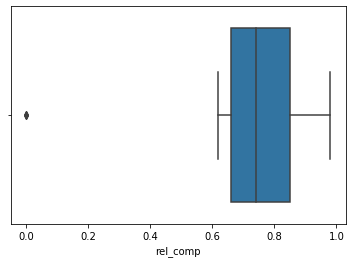

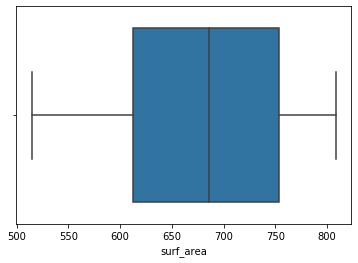

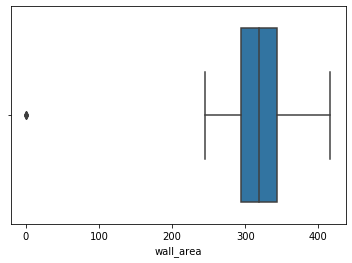

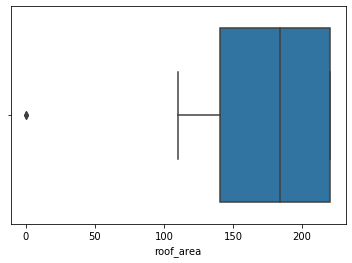

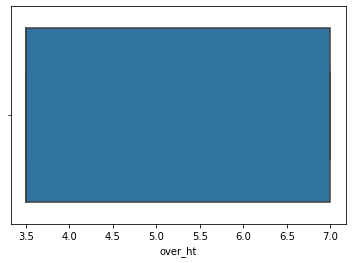

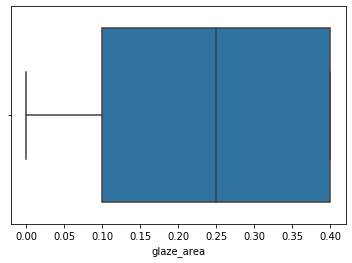

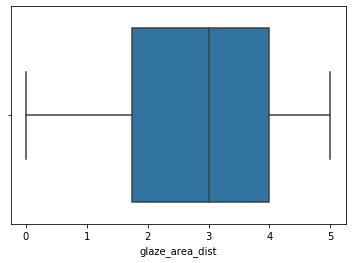

In [12]:
for cols in x_num.columns.values:
    sns.boxplot(x_num[cols])
    plt.show()

In [13]:
#func to remove outliers
def rm_out(df):
    for i,val in df.iteritems():
        u_thres = df[i].quantile(q=0.75)+1.5*(df[i].quantile(q=0.75)-df[i].quantile(q=0.25))
        l_thres = df[i].quantile(q=0.25)-1.5*(df[i].quantile(q=0.75)-df[i].quantile(q=0.25))
        df[i] = df[(df[i]>=l_thres) & (df[i]<=u_thres)][i]

In [14]:
rm_out(x_num)

In [15]:
x_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 7 columns):
rel_comp           759 non-null float64
surf_area          766 non-null float64
wall_area          761 non-null float64
roof_area          766 non-null float64
over_ht            766 non-null float64
glaze_area         768 non-null float64
glaze_area_dist    768 non-null int64
dtypes: float64(6), int64(1)
memory usage: 42.1 KB


##### Now we fill NA values

In [16]:
#for categorical values
for (colname, colvalues) in x_cat.iteritems():
    if x_cat[colname].isnull().sum() > (.3*x_cat.shape[0]):
        x_cat.drop([colname],inplace=True,axis=1)
    else:
        x_cat[colname].fillna(x_cat[colname].mode().iloc[0],inplace=True)

C:\Users\No_ob0dy\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [17]:
#for numerical values
for (colname, colvalues) in x_num.iteritems():
    if x_num[colname].isnull().sum() > (.3*x_num.shape[0]):
        x_num.drop([colname],inplace=True,axis=1)
    else:
        x_num[colname].fillna(x_num[colname].mean(),inplace=True)

In [18]:
x_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 1 columns):
orient    768 non-null object
dtypes: object(1)
memory usage: 6.1+ KB


In [19]:
x_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 7 columns):
rel_comp           768 non-null float64
surf_area          768 non-null float64
wall_area          768 non-null float64
roof_area          768 non-null float64
over_ht            768 non-null float64
glaze_area         768 non-null float64
glaze_area_dist    768 non-null int64
dtypes: float64(6), int64(1)
memory usage: 42.1 KB


##### Now we check for skewness and then standardize numerical data, after that we make dummies of the categorical data

In [20]:
skew = x_num.skew()
skew

rel_comp           0.502368
surf_area         -0.128214
wall_area          0.544175
roof_area         -0.167361
over_ht            0.005239
glaze_area        -0.060254
glaze_area_dist   -0.088689
dtype: float64

In [21]:
x_num['rel_comp']=np.cbrt(x_num['rel_comp'])
x_num['wall_area']=np.cbrt(x_num['wall_area'])

In [22]:
x_num.skew()

rel_comp           0.361663
surf_area         -0.128214
wall_area          0.294452
roof_area         -0.167361
over_ht            0.005239
glaze_area        -0.060254
glaze_area_dist   -0.088689
dtype: float64

In [23]:
#since the data is not skewed, we directly proceed to standardization
x_num = (x_num - x_num.mean())/x_num.std()

In [24]:
#Now we make dummies of categorical variable
x_cat_dums = pd.get_dummies(x_cat, drop_first=True)

##### Checking for skewness of the target variable

In [25]:
target.skew()
#it's very low, so no need of any transformation

cold_load    0.395992
dtype: float64

#### Now that the processing is done, we proceed to modeling

#### Model 1 - Simple Linear Regression

In [26]:
#concatenating the predictors variable
train1 = pd.concat([x_num,x_cat_dums],axis=1)

In [27]:
X_train1,X_test1,Y_train1,Y_test1 = train_test_split(train1,target,test_size=0.30,random_state=2)
print("X_train1",X_train1.shape)
print("X_test1",X_test1.shape)
print("Y_train1",Y_train1.shape)
print("Y_test1",Y_test1.shape)

X_train1 (537, 10)
X_test1 (231, 10)
Y_train1 (537, 1)
Y_test1 (231, 1)


In [28]:
#Building Linear Regression model using OLS
model1 = sm.OLS(Y_train1,X_train1).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              cold_load   R-squared (uncentered):                   0.768
Model:                            OLS   Adj. R-squared (uncentered):              0.764
Method:                 Least Squares   F-statistic:                              174.6
Date:                Sun, 22 Dec 2019   Prob (F-statistic):                   4.10e-160
Time:                        23:18:38   Log-Likelihood:                         -2120.8
No. Observations:                 537   AIC:                                      4262.
Df Residuals:                     527   BIC:                                      4304.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
rel_comp            3.9070      3.515      1.111      0.267      -2.998      10.812
surf_area          12.7478      4.906      2.598      0.010       3.110      22.385
wall_area          -2.7622      2.286     -1.208      0.227      -7.252       1.728
roof_area          -6.7917      4.822     -1.409      0.160     -16.263       2.680
over_ht            10.3350      2.584      4.000      0.000       5.259      15.411
glaze_area          2.2144      0.560      3.958      0.000       1.115       3.314
glaze_area_dist     0.0638      0.564      0.113      0.910      -1.044       1.172
orient_3           24.4534      1.119     21.848      0.000      22.255      26.652
orient_4           24.5503      1.089     22.552      0.000      22.412      26.689
orient_5           25.0450      1.079     23.215      0.000      22.926      27.164
==============================================================================
Omnibus:                       79.481   Durbin-Watson:                   1.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.518
Skew:                           1.054   Prob(JB):                     2.01e-23
Kurtosis:                       2.524   Cond. No.                         22.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
y_pred1 = model1.predict(X_test1)

In [30]:
print("Mean squared error for model1 is :",mean_squared_error(Y_test1,y_pred1))

Mean squared error for model1 is : 171.61494875841592


##### Model 2 - Ridge Regression

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
reg = Ridge()
params = [{'alpha':np.linspace(1,500,num=1000)}]
grid_search = GridSearchCV(estimator=reg, param_grid=params,cv = 10, verbose = 0)
grid_search = grid_search.fit(X_train1,Y_train1)

In [33]:
grid_search.best_params_

{'alpha': 1.4994994994994995}

In [34]:
reg1 = Ridge(alpha=1.499499)
model2= reg1.fit(X_train1,Y_train1)

In [35]:
y_pred2 = model2.predict(X_test1)
print("Mean Squared Error:",mean_squared_error(Y_test1,y_pred2))

Mean Squared Error: 12.40152099933028


In [36]:
from sklearn.metrics import r2_score
r2_sc1 = r2_score(Y_test1,y_pred2)
print("R2 score for model2 is:",r2_sc1)

R2 score for model2 is: 0.8628081746463133


In [37]:
ad_r2_sc1= 1 - (1-r2_sc1)*(len(Y_test1)-1)/(len(Y_test1)-X_test1.shape[1]-1)

In [38]:
print("Adjusted R2 score for model2 is:",ad_r2_sc1)

Adjusted R2 score for model2 is: 0.8565721825847821


##### Model3 - Lasso Regression

In [39]:
lasso =Lasso()
params = [{'alpha':np.linspace(1,500,num=1000)}]
grid_search1 = GridSearchCV(estimator=lasso, param_grid=params,cv = 10, verbose = 0)
grid_search1 = grid_search1.fit(X_train1,Y_train1)

In [40]:
grid_search1.best_params_

{'alpha': 1.0}

In [41]:
lasso1 = Lasso(alpha=1.0)
model3 = lasso1.fit(X_train1,Y_train1)

In [42]:
y_pred3 = model3.predict(X_test1)
print("Mean Squared Error:",mean_squared_error(Y_test1,y_pred3))

Mean Squared Error: 14.632557923535138


In [43]:
r2_sc2 = r2_score(Y_test1,y_pred3)
print("R2 score for model3 is:",r2_sc2)

R2 score for model3 is: 0.8381273287984798


In [44]:
ad_r2_sc2= 1 - (1-r2_sc2)*(len(Y_test1)-1)/(len(Y_test1)-X_test1.shape[1]-1)
print("Adjusted R2 score for model3 is:",ad_r2_sc2)

Adjusted R2 score for model3 is: 0.8307694801075016


##### Model 4 - Decision Tree Regressor

In [45]:
from sklearn.tree import DecisionTreeRegressor
reg2 = DecisionTreeRegressor()
params = {'criterion':['mse','friedman_mse','mae'],
          'splitter':['best','random'],
          'max_features':['auto','sqrt','log2']}
grid_search2 = GridSearchCV(estimator=reg2,param_grid=params,cv=10,verbose=0)
grid_search2 = grid_search2.fit(X_train1,Y_train1)

In [46]:
grid_search2.best_params_

{'criterion': 'friedman_mse', 'max_features': 'sqrt', 'splitter': 'best'}

In [47]:
y_pred4 = grid_search2.predict(X_test1)

In [48]:
print("Mean Squared Error:",mean_squared_error(Y_test1,y_pred4))

Mean Squared Error: 4.274035064935066


In [49]:
r2_sc3 = r2_score(Y_test1,y_pred4)
print("R2 score for model4 is:",r2_sc3)

R2 score for model4 is: 0.9527184873358865


In [50]:
ad_r2_sc3= 1 - (1-r2_sc3)*(len(Y_test1)-1)/(len(Y_test1)-X_test1.shape[1]-1)
print("Adjusted R2 score for model4 is:",ad_r2_sc3)

Adjusted R2 score for model4 is: 0.9505693276693359


##### Model 5 - Random Forest Regressor

In [51]:
from sklearn.ensemble import RandomForestRegressor
reg3 = RandomForestRegressor()

In [52]:
params = {'criterion':['mse','mae'],
          'max_features':['auto','sqrt','log2']}
grid_search3 = GridSearchCV(estimator=reg3,param_grid=params,cv=10,verbose=0)
grid_search3 = grid_search3.fit(X_train1,Y_train1)

C:\Users\No_ob0dy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\No_ob0dy\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\No_ob0dy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\No_ob0dy\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using rav

C:\Users\No_ob0dy\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\No_ob0dy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\No_ob0dy\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\No_ob0dy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
 

C:\Users\No_ob0dy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\No_ob0dy\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\No_ob0dy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\No_ob0dy\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using rav

C:\Users\No_ob0dy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\No_ob0dy\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\No_ob0dy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\No_ob0dy\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using rav

In [53]:
grid_search3.best_params_

{'criterion': 'mse', 'max_features': 'log2'}

In [54]:
y_pred5 = grid_search3.predict(X_test1)
print("Mean Squared Error:",mean_squared_error(Y_test1,y_pred5))

Mean Squared Error: 3.2211023419913416


In [55]:
r2_sc4 = r2_score(Y_test1,y_pred5)
print("R2 score for model4 is:",r2_sc4)

R2 score for model4 is: 0.9643665555238997


In [56]:
ad_r2_sc4= 1 - (1-r2_sc4)*(len(Y_test1)-1)/(len(Y_test1)-X_test1.shape[1]-1)
print("Adjusted R2 score for model4 is:",ad_r2_sc4)

Adjusted R2 score for model4 is: 0.9627468535022587
